In [ ]:
pip install geopandas==0.14.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.1.1
    Uninstalling geopandas-1.1.1:
      Successfully uninstalled geopandas-1.1.1


In [ ]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
import geopandas as gpd

In [ ]:
import survey_dict

catkeys = survey_dict.catkeys
catkeys2 = survey_dict.catkeys2

In [ ]:
# Function to remove rows where any keyword matches a category item
def filter_by_category_keywords(df, column_name, keywords):
    # Normalize keyword list
    keyword_set = set(k.strip().lower() for k in keywords)

    # Define match-check function
    def has_bad_category(cat_str):
        if pd.isna(cat_str):
            return False
        items = [item.strip().lower() for item in cat_str.split(',')]
        return any(item in keyword_set for item in items)

    # Filter out bad rows
    return df[~df[column_name].apply(has_bad_category)]

def get_sheet(dfs, sheetname = 'AI_Conference', removeamr=False, removeeng=False, returnorig=False, removeaionly=False):
  column_name = "Category"  # Replace with the actual column name
  df_xx1 = dfs[sheetname]
  if returnorig:
    #print(sheetname, len(df_xx1))
    return df_xx1
  #print(len(df_xx1))
  #print(len(df_xx1))
  # column_data = dfs['AI_Conference'][column_name]

  # Convert all values in "Cat" column to lowercase
  #df_xx1["Category"] = df_xx1["Category"].str.lower()
  df_xx1.loc[:, "Category"] = df_xx1["Category"].str.lower()
  df_xx1["Category"] = df_xx1["Category"].str.replace(r'\s+', ' ', regex=True)
  df_xx1.loc[:, "language"] = df_xx1["language"].str.lower()
  df_xx1["language"] = df_xx1["language"].str.replace(r'\s+', ' ', regex=True)
  df_xx1.loc[:, "title"] = df_xx1["title"].str.lower()
  df_xx1["title"] = df_xx1["title"].str.replace(r'\s+', ' ', regex=True)

  df_xx1 = df_xx1.dropna(subset=[column_name])
  if removeaionly:
    #print("remove ameica")
    #keywords2 = ['not-ai-related']
    #pattern2 = "|".join(keywords2)  # 'not-k|not-j|not-m'
    #df_xx1 = df_xx1[~df_xx1["Category"].str.contains(pattern2, na=False)]
    return df_xx1


  # Define keywords to remove
  keywords = ['not-ai-related', 'not-nlp', 'not-africa', "not nlp", "not africa", "deleted/withdrawn", "retracted", "repitition", "withdrawn", "tutorial", "workshop", "position paper", "survey", "proceedings", "duplicate", "thesis", "project", "technical report", "descriptive paper"] #
  # keywords = ['not-ai-related', 'not-nlp', 'not-africa', "not nlp", "not africa", "deleted/withdrawn", "retracted", "repitition", "withdrawn", "tutorial", "position paper", "survey", "proceedings", "duplicate", "thesis", "project", "descriptive paper"]


  # Create a regex pattern to match any of the keywords
  #escaped_keywords = [r'\b' + re.escape(kw) + r'\b' for kw in keywords]
  #pattern = "|".join(escaped_keywords)
  # Remove rows where "Cat" contains any of the keywords
  #df_xx1 = df_xx1[~df_xx1["Category"].str.contains(pattern, na=False)]
  # First keyword list
  df_xx1 = filter_by_category_keywords(df_xx1, "Category", keywords)

  if removeamr:
    #print("remove ameica")
    keywords2 = ['afamerican english']
    df_xx1 = filter_by_category_keywords(df_xx1, "language", keywords2)
  if removeeng:
    #print("remove ameica")
    keywords3 = ['only english']
    df_xx1 = filter_by_category_keywords(df_xx1, "language", keywords3)
    #pattern3 = "|".join(keywords3)  # 'not-k|not-j|not-m'
    #df_xx1 = df_xx1[~df_xx1["language"].str.contains(pattern3, na=False)]
  #print(len(df_xx1))
  return df_xx1

In [ ]:
def relevant_papers(data_categ):
  return sum([len(data_categ[item]) for item in data_categ])

def get_finaldata(removeamr=False, removeeng=False, returnorig=False, removeaionly=False):
  # Load the Excel file
  file_path = "final_emnlp_survey.xlsx" # "final_survey.xlsx"

  dfs = pd.read_excel(file_path, sheet_name=None, engine="openpyxl")  # Reads all sheets
  taskcat = dfs["Categories"][['nlp tasks',	'category']]
  #alltasks = [item.lower().strip() for item in dfs["Categories"]['Unnamed: 0'].tolist()]
  # Remove sheets using del
  #del dfs["sources"]
  #del dfs["Categories"]
  categories = ["AI_Conference", "ARXIV", "HCI_Conference", "IR_Knowledge", "NLP_Conference", "ML_Conference", "NLP_Journals", "Speech_Conference", "Speech_Journal", "Workshops", "ACL_Summit", "manual_papers"]
  data_categ = dict()
  for category in categories:
    catdf = get_sheet(dfs, sheetname = category, removeamr=removeamr, removeeng=removeeng, returnorig=returnorig, removeaionly=removeaionly)
    data_categ[category] = catdf
  return data_categ, taskcat

def gettopic(input_list = [], nrtasks=[], updatecat=False, catkeys=dict()):
  # Original list with comma-separated items
  #input_list = ['healthcare, classification, classification', 'sign language, education', 'academic', "classification"]

  # Final list to store unique items across the list
  final_list = []

  # Iterate through each item in the original list
  for item in input_list:
      # Split by comma, remove duplicates, and strip spaces
      sub_items = list(dict.fromkeys([sub_item.strip() for sub_item in item.split(',') if sub_item.strip()!=""]))
      presebtt  = [ttasak for ttasak in sub_items if ttasak in nrtasks]

      if updatecat == True:
         presebtt = list(set([catkeys.get(item, item) for item in presebtt]))
      #print(sub_items)
      # Add the cleaned sub-items to the final list
      final_list.extend(presebtt)
  return final_list

def get_task(data_categ, nrtasks, updatecat=False, startyear=2018, endyear=2024, catkeys=dict()):
  alltopics = []
  for item in data_categ:
    filtered_df = data_categ[item].query(f'{startyear} <= year <= {endyear}')
    # firstcat = gettopic(data_categ[item]["Category"])
    firstcat = gettopic(filtered_df["Category"], nrtasks=nrtasks, updatecat=updatecat, catkeys=catkeys)
    # firstcat  = [ttasak for ttasak in firstcat if ttasak in nrtasks]
    alltopics.extend(firstcat)
  # alltopics = [item for item in alltopics if item in nrtasks]
  return alltopics

def getlanguages(input_list = [], nrtasks=[], updatecat=False,):
  # Original list with comma-separated items
  #input_list = ['healthcare, classification, classification', 'sign language, education', 'academic', "classification"]

  # Final list to store unique items across the list
  final_list = []

  # Iterate through each item in the original list
  for item in input_list:
      # Split by comma, remove duplicates, and strip spaces
      sub_items = list(dict.fromkeys([sub_item.strip() for sub_item in item.split(',')]))

      final_list.extend(sub_items)
  return final_list

## start of plots

In [ ]:
def plot_topics2new(data_categ, alltasks, topk, updatecat=False, query="task", most="No", startyear=2018, endyear=2024, catkeys=dict()):
    tasks = alltasks.loc[alltasks["category"] == query.lower(), "nlp tasks"].tolist()
    alltopics = get_task(data_categ, tasks, updatecat=updatecat, startyear=startyear, endyear=endyear, catkeys=catkeys)
    # Count the frequency of each item

    counter = Counter(alltopics)
    # Get the top or bottom 'topk' items based on frequency
    if most == "Yes":
        topitem = counter.most_common(topk)
        title = f'Top frequent {query}'
    else:
        topitem = counter.most_common()[:-topk-1:-1]  # Least common items
        title = 'Least frequent Tasks'

    # Split the items and their frequencies for plotting
    items, frequencies = zip(*topitem)
    track = ['Interpreting and Analyzing NLP Models', "Human-Centered NLP", 'Ethics, Bias, and Fairness', 'NLP Applications']
    method = ['Efficient/Low-Resource Methods for NLP']
    bar_colors = ['#377eb8' if item in track else '#ff7f00'  if item in method else '#006400' for item in items]
    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(9, 12))
    bars = ax.barh(items, frequencies, color=bar_colors)
    ax.invert_yaxis()  # Highest value at the top

    # Determine the maximum frequency to set a threshold
    max_freq = max(frequencies)
    threshold = 0.15 * max_freq  # Adjust this value as needed

    # Add category labels inside or outside the bars based on bar width and index
    for i, (bar, label, freq) in enumerate(zip(bars, items, frequencies)):
        bar_width = bar.get_width()
        y_position = bar.get_y() + bar.get_height() / 2

        # Force labels for bars 3 to 5 (indices 2 to 4) to be outside
        if i in [1,2,3,4,5,6,7,8,9,10] or bar_width < threshold:
            # Place label just outside the bar
            ax.text(bar_width + max_freq * 0.01, y_position, label,
                    va='center', ha='left', color='black', fontsize=18)
        else:
            # Place label inside the bar
            ax.text(bar_width / 2, y_position, label,
                    va='center', ha='center', color='white', fontsize=18)

    # Axis labels and ticks
    ax.set_ylabel("Category", size=25)
    ax.set_xlabel('Paper Count', size=25)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticklabels([])  # Hide y-axis tick labels as labels are inside bars
    import matplotlib.patches as mpatches

    # Create legend handles
    met_patch = mpatches.Patch(color='#ff7f00', label='Methods')
    blue_patch = mpatches.Patch(color='#006400', label='Tasks')
    green_patch = mpatches.Patch(color='#377eb8', label='Themes')

    # Add legend to the plot
    ax.legend(handles=[met_patch,blue_patch, green_patch], loc='best', fontsize=18)

    plt.tight_layout()

    # Save the plot
    plt.savefig("plots/task.pdf", format='pdf')
    plt.savefig("plots/task.png", format='png')
    plt.show()

    return counter


def plot_lowres(data_categ, alltasks, topk, updatecat=False, query="task", most="No", startyear=2018, endyear=2024, catkeys=dict()):
    tasks = [item for item in catkeys2]
    print(tasks)
    alltopics = get_task(data_categ, tasks, updatecat=updatecat, startyear=startyear, endyear=endyear, catkeys=catkeys)
    # Count the frequency of each item

    counter = Counter(alltopics)
    # Get the top or bottom 'topk' items based on frequency
    if most == "Yes":
        topitem = counter.most_common(topk)
        title = f'Top frequent {query}'
    else:
        topitem = counter.most_common()[:-topk-1:-1]  # Least common items
        title = 'Least frequent Tasks'

    # Split the items and their frequencies for plotting
    items, frequencies = zip(*topitem)

    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(8, 8))
    bars = ax.barh(items, frequencies, color='#006400')
    ax.invert_yaxis()  # Highest value at the top

    # Determine the maximum frequency to set a threshold
    max_freq = max(frequencies)
    threshold = 0.15 * max_freq  # Adjust this value as needed

    # Add category labels inside or outside the bars based on bar width and index
    for i, (bar, label, freq) in enumerate(zip(bars, items, frequencies)):
        bar_width = bar.get_width()
        y_position = bar.get_y() + bar.get_height() / 2

        # Force labels for bars 3 to 5 (indices 2 to 4) to be outside
        if i in [1,2,3,4,5,6,7,8,9,10] or bar_width < threshold:
            # Place label just outside the bar
            ax.text(bar_width + max_freq * 0.01, y_position, label,
                    va='center', ha='left', color='black', fontsize=18)
        else:
            # Place label inside the bar
            ax.text(bar_width / 2, y_position, label,
                    va='center', ha='center', color='white', fontsize=18)

    # Axis labels and ticks
    ax.set_ylabel("Low-resource Technique", size=25)
    ax.set_xlabel("Paper Count", size=25)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticklabels([])  # Hide y-axis tick labels as labels are inside bars

    plt.tight_layout()

    # Save the plot
    plt.savefig("plots/lores.pdf", format='pdf')
    plt.savefig(f"plots/lores.png", format='png')
    plt.show()

    return counter

# plot the year freq
def plot_year_frequencies(years, query='Year', save=True, name="plots/yearfreq.pdf"):
    # Count the frequency of each year
    counter = Counter(years)

    # Sort the items by year for better visual order
    items = sorted(counter.keys())
    frequencies = [counter[year] for year in items]
    # items = [str(int(year)) if year != 2024 else "2024\ntill Nov." for year in items]
    items = [str(int(year)) if year != 2024 else "2024" for year in items]
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.bar(items, frequencies, color='#006400')  # Vertical bar chart
    plt.xlabel(query, size=30)
    plt.ylabel('Paper Count', size=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(0, 250)
    plt.tight_layout()
    if save:
      plt.savefig(name, format='pdf')
      plt.savefig(f"{name}.png", format='png')
    plt.show()

    return counter

In [ ]:

from matplotlib.patches import Patch
def plot_languages(data_categ, topk=50, query="task", most="No", startyear=2018, endyear=2024, titlen=False, save=""):
  alllangs = []
  for item in data_categ:
    filtered_df = data_categ[item].query(f'{startyear} <= year <= {endyear}')
    datas = filtered_df["language"].fillna("Unknown")
    firstcat = getlanguages(datas)
    alllangs.extend([lang for lang in firstcat if lang in afg1b])# or "englishx" in lang or "african" in lang])

  counter = Counter(alllangs)
  print("total languages = ", len(counter), counter)
  # Count how many keys have counts < 10
  num_less_than_10 = sum(1 for count in counter.values() if count < 10)
  # Total number of keys
  total_keys = len(counter)
  # Proportion
  proportion = num_less_than_10 / total_keys
  print(f"Proportion of keys with counts < 10: {proportion:.4f}")

  num_less_than_5 = sum(1 for count in counter.values() if count < 5)
  # Proportion
  proportion = num_less_than_5 / total_keys
  print(f"Proportion of keys with counts < 5: {proportion:.4f}")


  langfam = [resulttree[langtreedict[lang]] for lang in counter if lang in afg1b and lang in langtreedict]
  counterfam = Counter(langfam)
  print(counterfam)
  plot_family(counterfam, topk=topk, save=save.replace(".pdf","_family.pdf"))

  # Get the top 100 items based on frequency
  if most == "Yes":
    topitem = counter.most_common(topk)
    title = (f'Top-{topk} Languages')
  else:
    # Get the least common items
    topitem = counter.most_common()[:-topk-1:-1]  # Gets the least common 'topk' elements
    title = (f'Least-{topk} Languages')

  # Split the items and their frequencies for plotting
  items, frequencies = zip(*topitem)
  # get langs with the highest speakers
  langpop = pd.read_csv("linguameta.tsv", sep="\t")
  filtered_langpop = langpop.dropna(subset=['bcp_47_code', 'estimated_number_of_speakers'])
  langpop_dict = dict(zip(filtered_langpop['iso_639_3_code'], filtered_langpop['estimated_number_of_speakers']))
  langnames_dict = dict(zip(glot1['ISO639P3code'], glot1['Name']))

  langpop_dict['swh'] = langpop_dict['swa']
  newlangpop_dict = dict()
  for lang in langpop_dict:
    if lang in langnames_dict:
      newlangpop_dict[langnames_dict[lang].lower()] = langpop_dict[lang]
  spk_counter = Counter(newlangpop_dict)
  topkspeakes= [lang[0] for lang in spk_counter.most_common(topk)]
  # end of getting langs
  labels = [f"{item.title()}$^{{\\dagger}}$" if item in topkspeakes else item.title() for item in items]

  # Create a horizontal bar plot
  plt.figure(figsize=(10, 8))
  plt.barh(labels, frequencies, color='#006400')  # Make bars green
  plt.gca().invert_yaxis()  # Highest value at the top

  # Set labels with larger font sizes
  plt.ylabel('Language', size=30)
  plt.xlabel('Paper Count', size=30)
  if titlen:
    plt.title(title, size=30)

  # Increase tick font sizes
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  # Add the 'title' as a legend
  if not titlen:
    #plt.legend([title], loc='lower right', fontsize=20, frameon=False)
    # Create an invisible handle for legend (no color)
    empty_patch = Patch(facecolor='none', edgecolor='none', label=title)
    # Add the legend only with text
    plt.legend(handles=[empty_patch], loc='lower right', fontsize=20, frameon=False)

  plt.tight_layout()
  # Save the plot as a PDF file

  plt.savefig(save, format='pdf')
  plt.savefig(f"{save}.png", format='png')
  plt.show()

def plot_family(counter, topk=20, save = None):
  topitem = counter.most_common(topk)
  items, frequencies = zip(*topitem)

  plt.figure(figsize=(10, 8))
  plt.barh(items, frequencies, color='#006400')  # Make bars green
  plt.gca().invert_yaxis()  # Highest value at the top

  # Set labels with larger font sizes
  plt.ylabel('Language Family', fontsize=30)
  plt.xlabel('Paper Count', fontsize=30)
  title = (f'Top-{topk} Language families')

  # Increase tick font sizes
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  # If title is not set, add an invisible legend
  if title:
      empty_patch = Patch(facecolor='none', edgecolor='none', label=title)
      plt.legend(handles=[empty_patch], loc='lower right', fontsize=20, frameon=False)

  plt.tight_layout()

  # Save the plot as a PDF file
  if save!=None:
    plt.savefig(save, format='pdf')
    plt.savefig(f"{save}.png", format='png')
  plt.show()

In [ ]:
def plotlangcounttalk(counter, topk=50, most="No", titlen=False, save=""):
   # Get the top 100 items based on frequency
  if most == "Yes":
    topitem = counter.most_common(topk)
    title = (f'Top-{topk} Languages')
  else:
    # Get the least common items
    topitem = counter.most_common()[:-topk-1:-1]  # Gets the least common 'topk' elements
    title = (f'Least-{topk} Languages')

  # Split the items and their frequencies for plotting
  items, frequencies = zip(*topitem)
  # get langs with the highest speakers
  langpop = pd.read_csv("linguameta.tsv", sep="\t")
  filtered_langpop = langpop.dropna(subset=['bcp_47_code', 'estimated_number_of_speakers'])
  langpop_dict = dict(zip(filtered_langpop['iso_639_3_code'], filtered_langpop['estimated_number_of_speakers']))
  langnames_dict = dict(zip(glot1['ISO639P3code'], glot1['Name']))

  langpop_dict['swh'] = langpop_dict['swa']
  newlangpop_dict = dict()
  for lang in langpop_dict:
    if lang in langnames_dict:
      newlangpop_dict[langnames_dict[lang].lower()] = langpop_dict[lang]
  spk_counter = Counter(newlangpop_dict)
  topkspeakes= [lang[0] for lang in spk_counter.most_common(topk)]
  # end of getting langs
  labels = [f"{item.title()}$^{{\\dagger}}$" if item in topkspeakes else item.title() for item in items]
  color = ['#006400' if item in topkspeakes else "#999999" for item in items]

  # Create a horizontal bar plot
  plt.figure(figsize=(12, 10))
  plt.barh(labels, frequencies, color=color)  # Make bars green
  plt.gca().invert_yaxis()  # Highest value at the top

  # Set labels with larger font sizes
  plt.ylabel('Language', size=30)
  plt.xlabel('Paper Count', size=30)
  if titlen:
    plt.title(titlen, size=18)

  # Increase tick font sizes
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  # Add the 'title' as a legend
  if not titlen:
    #plt.legend([title], loc='lower right', fontsize=20, frameon=False)
    # Create an invisible handle for legend (no color)
    empty_patch = Patch(facecolor='none', edgecolor='none', label=title)
    # Add the legend only with text
    plt.legend(handles=[empty_patch], loc='lower right', fontsize=20, frameon=False)

  plt.tight_layout()
  # Save the plot as a PDF file

  plt.savefig(save, format='pdf')
  plt.savefig(f"{save}.png", format='png')
  plt.show()
  return spk_counter

def plotlangcount(counter, topk=50, most="No", titlen=False, save=""):
   # Get the top 100 items based on frequency
  if most == "Yes":
    topitem = counter.most_common(topk)
    title = (f'Top-{topk} Languages')
  else:
    # Get the least common items
    topitem = counter.most_common()[:-topk-1:-1]  # Gets the least common 'topk' elements
    title = (f'Least-{topk} Languages')

  # Split the items and their frequencies for plotting
  items, frequencies = zip(*topitem)
  # get langs with the highest speakers
  langpop = pd.read_csv("linguameta.tsv", sep="\t")
  filtered_langpop = langpop.dropna(subset=['bcp_47_code', 'estimated_number_of_speakers'])
  langpop_dict = dict(zip(filtered_langpop['iso_639_3_code'], filtered_langpop['estimated_number_of_speakers']))
  langnames_dict = dict(zip(glot1['ISO639P3code'], glot1['Name']))

  langpop_dict['swh'] = langpop_dict['swa']
  newlangpop_dict = dict()
  for lang in langpop_dict:
    if lang in langnames_dict:
      newlangpop_dict[langnames_dict[lang].lower()] = langpop_dict[lang]
  spk_counter = Counter(newlangpop_dict)
  topkspeakes= [lang[0] for lang in spk_counter.most_common(topk)]
  # end of getting langs
  labels = [f"{item.title()}$^{{\\dagger}}$" if item in topkspeakes else item.title() for item in items]

  # Create a horizontal bar plot
  plt.figure(figsize=(10, 8))
  plt.barh(labels, frequencies, color='#006400')  # Make bars green
  plt.gca().invert_yaxis()  # Highest value at the top

  # Set labels with larger font sizes
  plt.ylabel('Language', size=30)
  plt.xlabel('Paper Count', size=30)
  if titlen:
    plt.title(title, size=30)

  # Increase tick font sizes
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  # Add the 'title' as a legend
  if not titlen:
    #plt.legend([title], loc='lower right', fontsize=20, frameon=False)
    # Create an invisible handle for legend (no color)
    empty_patch = Patch(facecolor='none', edgecolor='none', label=title)
    # Add the legend only with text
    plt.legend(handles=[empty_patch], loc='lower right', fontsize=20, frameon=False)

  plt.tight_layout()
  # Save the plot as a PDF file

  plt.savefig(save, format='pdf')
  plt.savefig(f"{save}.png", format='png')
  plt.show()
  return spk_counter

**read glotlog**

In [ ]:
import pandas as pd

def readglottolog():
  glotlog = pd.read_csv("languages.csv")
  glotlog_trees = pd.read_csv("trees.csv")
  afrolid = pd.read_csv("supported-languages", sep="\t")

  africa = glotlog[glotlog['Macroarea'] == 'Africa'][["Name","ISO639P3code"]]#.dropna()
  glot1 = glotlog[glotlog['Macroarea'] == 'Africa'][["ISO639P3code","Name"]]#.dropna()
  glot1 = glotlog[glotlog['Macroarea'] == 'Africa'][["ISO639P3code","Name"]]#.dropna()
  afg1 = set(glot1['ISO639P3code'].tolist())
  afg1b = set([item.lower() for item in glot1['Name'].tolist()])
  afg2 = set(afrolid['ISO-3'].tolist())

  return glotlog, glotlog_trees, glot1, afg1b, afg2

def read_family(glotlog_trees):
  dftree = glotlog_trees[['ID', 'Description']]
  # Create dictionary
  resulttree = {}

  for idx, row in dftree.iterrows():
      id_val = row['ID']
      desc = row['Description']
      # Split at 'family' and take the part after
      if 'family' in desc:
          value = desc.split('family', 1)[1].strip()
          resulttree[id_val] = value
      else:
          resulttree[id_val] = desc  # fallback if "family" not in t
  return resulttree

In [ ]:
# find title repitions
def merge_and_find_repetition(dfs):
    # First, lowercase the 'title' column in each DataFrame
    for i, df in enumerate(dfs):
        dfs[i]['title'] = dfs[i]['title'].str.lower()

    # Merge all DataFrames on the 'title' column
    merged_df = pd.concat(dfs, ignore_index=True)

    # Count repetitions of titles across the merged DataFrame
    repetitions = merged_df['title'].value_counts()

    # Filter titles that appear more than once
    repeated_titles = repetitions[repetitions > 1]

    return repeated_titles

In [ ]:
glotlog, glotlog_trees, glot1, afg1b, afg2 = readglottolog()
langtree = glotlog[glotlog['Macroarea'] == 'Africa'][['Name', 'Family_ID']].dropna()
# Create dictionary
langtreedict = {row['Name'].lower(): row['Family_ID'] for idx, row in langtree.iterrows()}
resulttree = read_family(glotlog_trees)

# get initial stats


1.   How man papers were originally collected per category?
2.   How many were survey papers, delered/withdrawn 'not-ai-related', 'not-nlp', 'not-africa' ?



In [ ]:
def print_stat(origdata):
  totalcol = 0
  categories = ["AI_Conference", "ARXIV", "HCI_Conference", "IR_Knowledge", "NLP_Conference", "ML_Conference", "NLP_Journals", "Speech_Conference", "Speech_Journal", "Workshops", "ACL_Summit", "manual_papers"]
  for cat in categories:
    totalcol += len(origdata[cat])
    print(cat, len(origdata[cat]))
  print("Total collected = ", totalcol)

In [ ]:
origdata, _ = get_finaldata(removeamr=False, removeeng=False, returnorig=True)
print_stat(origdata)

AI_Conference 2222
ARXIV 11680
HCI_Conference 1290
IR_Knowledge 1507
NLP_Conference 2654
ML_Conference 4804
NLP_Journals 124
Speech_Conference 2412
Speech_Journal 279
Workshops 360
ACL_Summit 52
manual_papers 209
Total collected =  27593


In [ ]:
origdata2, _ = get_finaldata(removeamr=False, removeeng=False, returnorig=False, removeaionly=True)
print_stat(origdata2)

AI_Conference 2222
ARXIV 2199
HCI_Conference 188
IR_Knowledge 1507
NLP_Conference 2654
ML_Conference 4804
NLP_Journals 124
Speech_Conference 2412
Speech_Journal 279
Workshops 360
ACL_Summit 52
manual_papers 209
Total collected =  17010


**How many relevant papers?**

In [ ]:
data_categ, alltasks = get_finaldata(removeamr=True, removeeng=True)
print("Total #papers not tagged as non-African, not-NLP and not-AI = ", relevant_papers(data_categ)) # , returnorig=False)

Total #papers not tagged as non-African, not-NLP and not-AI =  884


In [ ]:
categoriesx = []
for k in data_categ:
  categoriesx.extend(data_categ[k]["Category"].tolist())
allcatsg = [item.strip().split(",") for item in categoriesx]
flatallcatsg = set([item.strip().lower() for sublist in allcatsg for item in sublist])
allertasks = set([item.strip().lower() for item in alltasks["nlp tasks"].tolist()])
print(allertasks - flatallcatsg)
print(flatallcatsg - allertasks)

{'social linguistics', 'word-in-context semantic judgment', 'propaganda detection', 'proceedings', 'sign language understanding', 'semantic lexicon', 'self-structuring autoencoder', 'whistled speech', 'sociolinguistics', 'syntactic dependencies', 'syntax', 'tone recognition', 'recruitment', 'data literacy', 'offensive speech dynamics', 'aspect-based sentiment analysis', 'reddit', 'language development', 'rna sequence analysis', 'factuality', 'phonetic analysis', 'task', 'democratization', 'dialect density', 'neural vocoder', 'knowledge discovery', 'facial recognition', 'acoustic correlates', 'ict policy', 'normalizing flows', 'knowledge representation', 'misinformation', 'rag', 'onto-norms', 'nlp for social sciences', 'generative ai ethics', 'crime', 'stable diffusion', 'document classification', 'noisy text processing', 'language surrogates', 'speech timing', 'multilingual ir', 'image classification', 'spoken language understanding', 'toxicity assessment', 'project', 'mental health pr

In [ ]:
print_stat(data_categ)

AI_Conference 6
ARXIV 188
HCI_Conference 8
IR_Knowledge 8
NLP_Conference 209
ML_Conference 10
NLP_Journals 14
Speech_Conference 92
Speech_Journal 11
Workshops 124
ACL_Summit 5
manual_papers 209
Total collected =  884


In [ ]:
# any repeated paper?
data_categx = [data_categ[item] for item in data_categ]
merge_and_find_repetition(data_categx)

,count
title,


**How man papers per year?**

In [ ]:
# count unique african languages per row
def count_unique_african(items_str):
    if pd.isna(items_str) or items_str.strip() == "":
        return 0
    # Split by comma, strip whitespace, lower-case for consistency
    items = [item.strip() for item in items_str.split(",")]
    # Filter out "non-african languages"
    filtered = [item for item in items if item.lower() in afg1b]
    # Get unique items
    unique_items = set(filtered)
    # Return count
    return len(unique_items)

def mergeallcat(data_categ, startyear=2019, endyear=2024):
  allpapers = []
  for item in data_categ:
    filtered_df = data_categ[item].query(f'{startyear} <= year <= {endyear}')
    allpapers.append(filtered_df[["title", "url", "year", "Category", "language","Data?", "cross-cultural?", "translated?"]])
  merged_df = pd.concat(allpapers, ignore_index=True)
  return merged_df

def rankpaper_lang(data_categ, startyear=2019, endyear=2024):
  merged_df = mergeallcat(data_categ, startyear=startyear, endyear=endyear)
  merged_df['count'] = merged_df['language'].apply(count_unique_african)
  merged_df = merged_df.sort_values(by='count', ascending=False)
  return merged_df

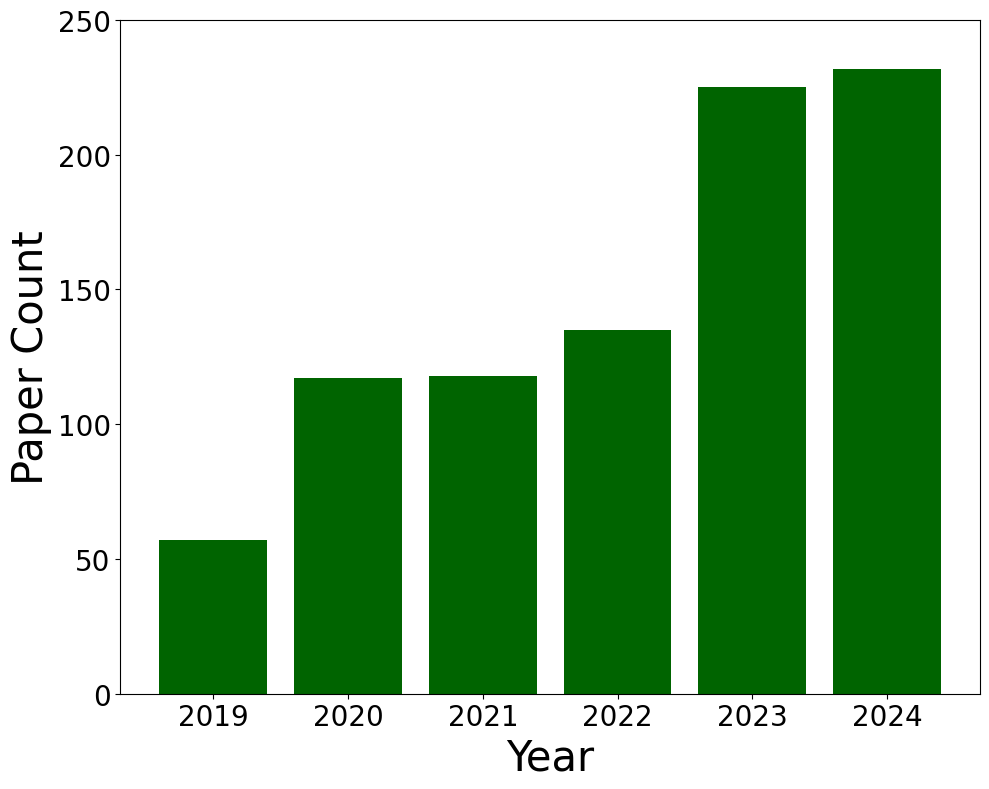

Counter({2023: 225, 2024: 232, 2022: 135, 2019: 57, 2020: 117, 2021: 118})

In [ ]:
# how many papers eeach year
ranp = rankpaper_lang(data_categ, startyear=2019, endyear=2024)
plot_year_frequencies(ranp.year, name="plots/yearfreq.pdf")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2685039204.py:2: SyntaxWarning: invalid escape sequence '\s'
  ranp_filtered = ranp[~ranp['Category'].str.contains('shared[\s]?task', case=False, na=False)]


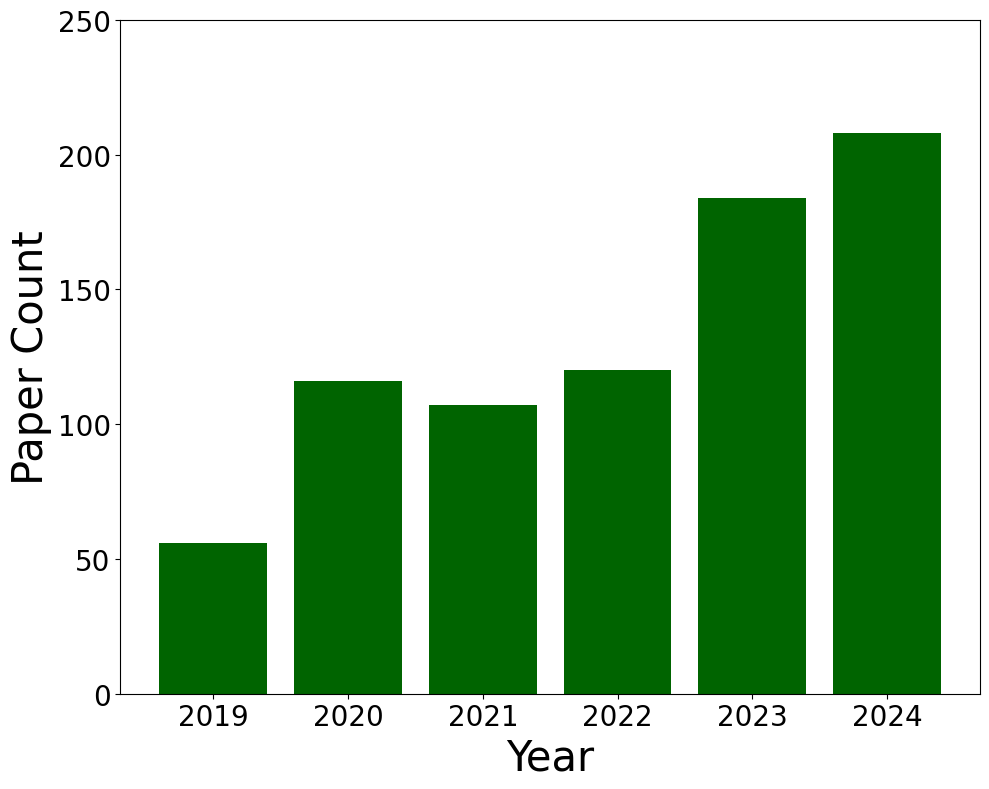

Counter({2023: 184, 2024: 208, 2022: 120, 2019: 56, 2020: 116, 2021: 107})

In [ ]:
# Remove rows where 'category' contains 'sharedtask'
ranp_filtered = ranp[~ranp['Category'].str.contains('shared[\s]?task', case=False, na=False)]
plot_year_frequencies(ranp_filtered.year, save=True, name="plots/yearfreq_st.pdf")

## what language?

In [ ]:
def getlanguagecount(data_categ, query="task", startyear = 2019, endyear = 2024, topk=20):
  alllangs = []
  megdata = mergeallcat(data_categ)
  filtered_df = megdata[(megdata["year"] >= startyear) & (megdata["year"] <= endyear)]
  datas = filtered_df["language"].fillna("Unknown")
  firstcat = getlanguages(datas)
  alllangs.extend([lang for lang in firstcat if lang in afg1b])
  counter = Counter(alllangs)

  print("total languages = ", len(counter), counter)
  # Count how many keys have counts < 10
  num_less_than_10 = sum(1 for count in counter.values() if count < 10)
  # Total number of keys
  total_keys = len(counter)
  # Proportion
  proportion = num_less_than_10 / total_keys
  print(f"Proportion of languages with counts < 10: {proportion:.4f}")

  num_less_than_5 = sum(1 for count in counter.values() if count < 5)
  # Proportion
  proportion = num_less_than_5 / total_keys
  print(f"Proportion of languages with counts < 5: {proportion:.4f}")
  return counter

total languages =  2275 Counter({'swahili': 325, 'yoruba': 254, 'hausa': 253, 'amharic': 252, 'igbo': 195, 'zulu': 186, 'afrikaans': 184, 'kinyarwanda': 171, 'xhosa': 167, 'somali': 156, 'wolof': 139, 'ganda': 119, 'tswana': 116, 'nigerian pidgin': 116, 'shona': 115, 'tigrinya': 105, 'tsonga': 105, 'moroccan arabic': 102, 'southern sotho': 102, 'west central oromo': 101, 'pedi': 97, 'nyanja': 96, 'egyptian arabic': 92, 'luo (kenya and tanzania)': 90, 'bambara': 88, 'twi': 88, 'kinshasa lingala': 87, 'plateau malagasy': 83, 'algerian arabic': 77, 'swati': 76, 'fon': 70, 'tunisian arabic': 64, 'ewe': 63, 'rundi': 63, 'kikuyu': 53, 'venda': 51, 'umbundu': 50, 'kabuverdianu': 48, 'kabyle': 48, 'mossi': 46, 'sango': 46, 'south transvaal ndebele': 44, 'hausa states fulfulde': 43, 'dyula': 40, 'tumbuka': 39, 'tamasheq': 36, 'akan': 36, 'bemba (zambia)': 36, 'kabiyé': 36, 'southwestern dinka': 35, 'kimbundu': 34, 'luba-lulua': 34, 'nuer': 34, 'fula': 33, 'chokwe': 33, 'wolaytta': 32, 'acoli': 

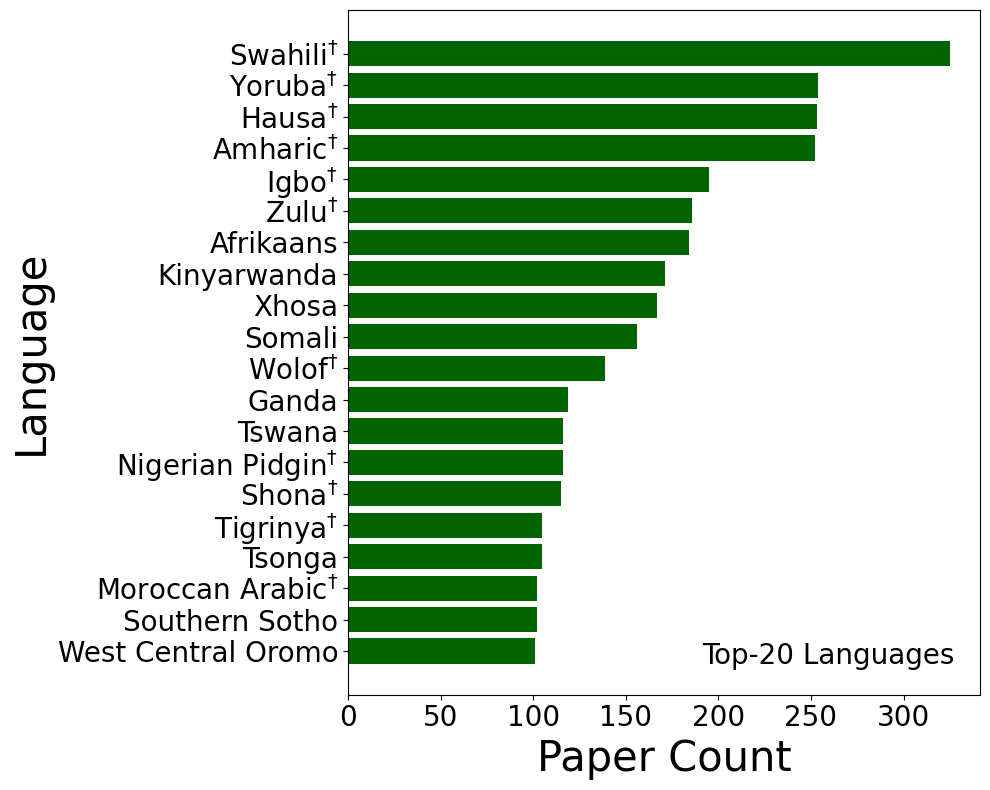

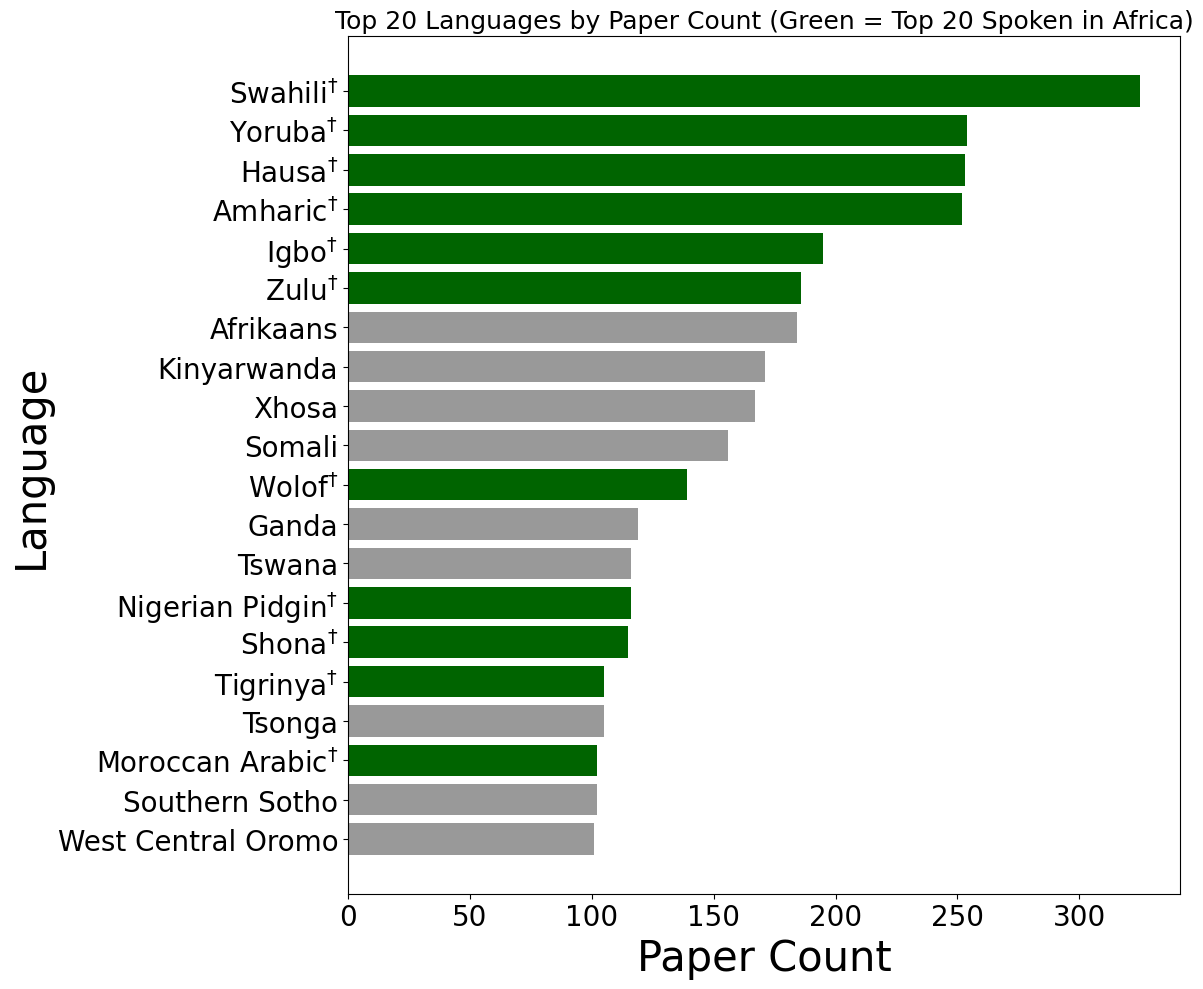

In [ ]:
topk=20
langcount = getlanguagecount(data_categ, query="task", startyear = 2019, endyear = 2024, topk=20)
spk_counter = plotlangcount(langcount, topk=topk, most="Yes", titlen=False,  save="plots/top_languages.pdf")
spk_countertalk = plotlangcounttalk(langcount, topk=topk, most="Yes", titlen="Top 20 Languages by Paper Count (Green = Top 20 Spoken in Africa)",  save="plots/top_languages_talk.pdf")

In [ ]:
# get rank of some languages?
def rank_counter(counter):
    # Sort by count descending, then by key for tie-breaking (optional)
    sorted_items = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    rank_dict = {}
    rank = 1
    prev_count = None
    for idx, (item, count) in enumerate(sorted_items):
        if count != prev_count:
            rank = idx + 1  # Update rank only when count changes
            prev_count = count
        rank_dict[item] = rank

    return rank_dict

# Step 3: Function to get rank of a key
def get_rank(key):
    return rank_map.get(key, None)  # Returns None if key is not found

In [ ]:
# Create rank mapping
rank_map = rank_counter(spk_counter)
for item in ["kinyarwanda", "afrikaans", "somali", "ganda", "tswana", "tsonga", "pedi"]:
  print(item, get_rank(item), spk_counter[item])
#tswana, Pedi, and Tsonga with just 2.5M speakers

kinyarwanda 23 9800000.0
afrikaans 35 7300000.0
somali 26 9200000.0
ganda 40 5600000.0
tswana 39 6000000.0
tsonga 83 2500000.0
pedi 45 5300000.0


In [ ]:
query="task"
startyear = 2019
endyear = 2024
alllangs = []
megdata = mergeallcat(data_categ)
filtered_df = megdata[(megdata["year"] >= startyear) & (megdata["year"] <= endyear)]
datas = filtered_df["language"].fillna("Unknown")

In [ ]:
# Final list to store unique items across the list
final_list = []

# Iterate through each item in the original list
for item in datas:
  # Split by comma, remove duplicates, and strip spaces
  sub_items = list(dict.fromkeys([sub_item.strip() for sub_item in item.split(',')]))
  final_list.append(sub_items)

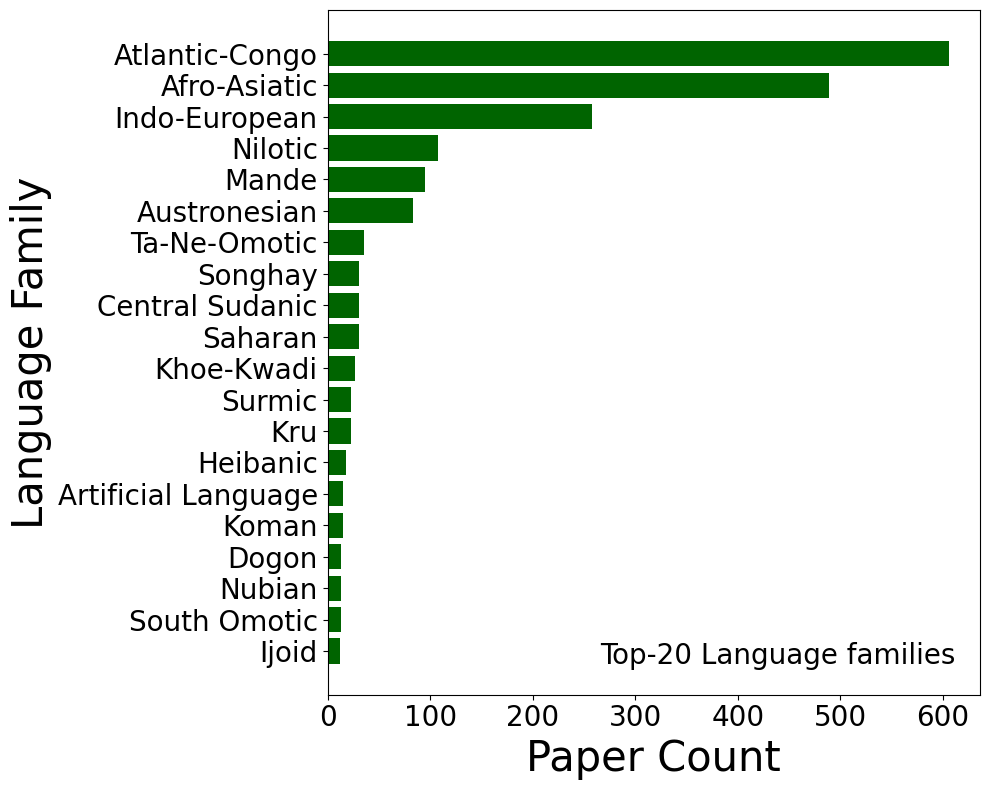

In [ ]:
final_lf = []
for lang in final_list:
  final_lf.extend(list(set([resulttree[langtreedict[item]]  for item in lang if item in afg1b and item in langtreedict])))
counterfam = Counter(final_lf)
plot_family(counterfam, topk=20, save="plots/top_languages_family.pdf")

In [ ]:
#plot_languages(data_categ, topk=20, query="task", most="Yes", startyear=2019, endyear=2024, titlen=False, save="plots/top_languages.pdf")

**Which task and which techniques?**

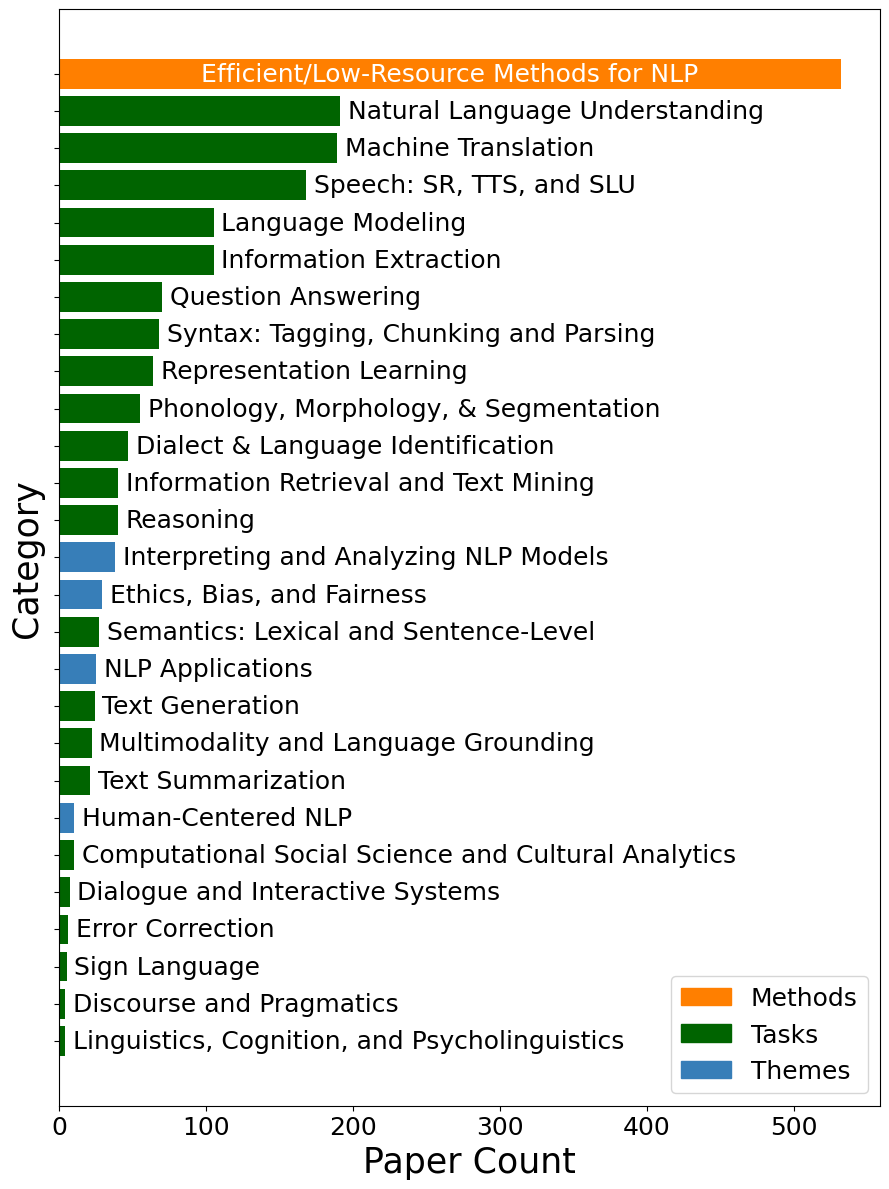

0 []


In [ ]:
# themes, low-resource techniques, task
query="Task"
catkeys3 = catkeys|catkeys2
tcounter = plot_topics2new(data_categ, alltasks, 70, updatecat=True, query=query, most="Yes", startyear=2019, endyear=2024, catkeys=catkeys)
# Get items with count of 1
items_with_count_1 = [item for item, count in tcounter.items() if count == 1]
print(len(items_with_count_1), items_with_count_1)

In [ ]:
tcounter

Counter({'Speech: SR, TTS, and SLU': 168,
         'Efficient/Low-Resource Methods for NLP': 532,
         'Natural Language Understanding': 191,
         'NLP Applications': 25,
         'Language Modeling': 105,
         'Information Retrieval and Text Mining': 40,
         'Sign Language': 5,
         'Representation Learning': 64,
         'Dialect & Language Identification': 47,
         'Question Answering': 70,
         'Machine Translation': 189,
         'Error Correction': 6,
         'Reasoning': 40,
         'Ethics, Bias, and Fairness': 29,
         'Text Generation': 24,
         'Text Summarization': 21,
         'Interpreting and Analyzing NLP Models': 38,
         'Dialogue and Interactive Systems': 7,
         'Information Extraction': 105,
         'Semantics: Lexical and Sentence-Level': 27,
         'Multimodality and Language Grounding': 22,
         'Syntax: Tagging, Chunking and Parsing': 68,
         'Phonology, Morphology, & Segmentation': 55,
         'Human-

['audit', 'data filtering', 'annotation projection', 'data selection', 'active learning', 'distant supervision', 'weak supervision', 'data augmentation', 'transfer learning', 'cross-lingual transfer', 'adaptive pretraining', 'compression', 'data pruning', 'pruning', 'quantization', 'cross-lingual alignment', 'multi-task learning', 'model fusion', 'representation fusion', 'ensemble learning', 'rule-based nlp', 'dictionary-based nlp', 'knowledge distillation', 'noisy labeling', 'meta learning', 'meta-learning', 'back translation', 'vocabulary extension']


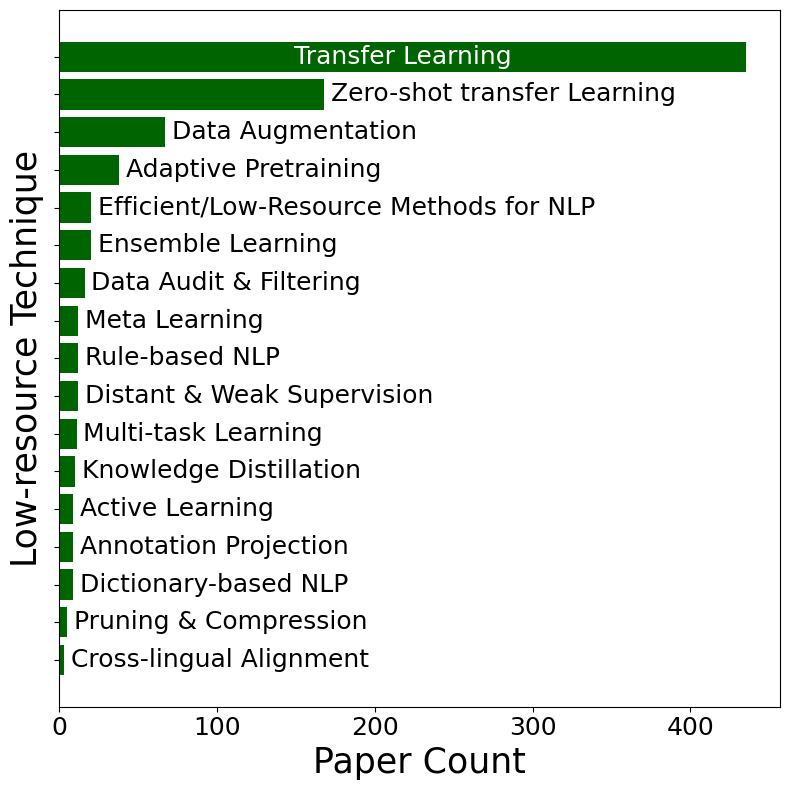

In [ ]:
tcounter = plot_lowres(data_categ, alltasks, 70, updatecat=True, query=query, most="Yes", startyear=2019, endyear=2024,catkeys=catkeys2)

In [ ]:
tcounter

Counter({'Transfer Learning': 435,
         'Adaptive Pretraining': 38,
         'Zero-shot transfer Learning': 168,
         'Meta Learning': 12,
         'Rule-based NLP': 12,
         'Data Audit & Filtering': 16,
         'Data Augmentation': 67,
         'Active Learning': 9,
         'Multi-task Learning': 11,
         'Distant & Weak Supervision': 12,
         'Efficient/Low-Resource Methods for NLP': 20,
         'Knowledge Distillation': 10,
         'Cross-lingual Alignment': 3,
         'Pruning & Compression': 5,
         'Annotation Projection': 9,
         'Dictionary-based NLP': 9,
         'Ensemble Learning': 20})

**How many countries are covered?**

In [ ]:
def getlang(input_list = []):
  # Original list with comma-separated items
  #input_list = ['healthcare, classification, classification', 'sign language, education', 'academic', "classification"]

  # Final list to store unique items across the list
  final_list = []

  # Iterate through each item in the original list
  for item in input_list:
      # Split by comma, remove duplicates, and strip spaces
      sub_items = list(dict.fromkeys([sub_item.strip() for sub_item in item.split(',')]))

      # Add the cleaned sub-items to the final list
      final_list.append(sub_items)
  return final_list

def getcount():
  with open("language-country.json") as f:
    countries = json.load(f)
  lowercase_countries = {k.lower(): v for k, v in countries.items()}
  return lowercase_countries

def getcountries2(data_categ, startyear =  2018, endyear = 2022):
  alllangs = []
  countries = []
  lowercase_countries = getcount()
  for item in data_categ:
    filtered_df = data_categ[item].query(f'{startyear} <= year <= {endyear}')
    datas = filtered_df["language"].fillna("Unknown")
    firstcat = getlang(datas)
    #print(firstcat)
    for lists in firstcat:
      list_of_lists = [lowercase_countries[lang] for lang in lists if lang in afg1b and lang  in lowercase_countries]
      outlist = [item for sublist in list_of_lists for item in sublist]
      #print(outlist)
      countries.extend(list(set(outlist))) # or "english" in lang or "african" in lang])
  #countries_cov = [lowercase_countries[countr]['Country'] for countr in set(alllangs) if countr  in lowercase_countries ]
  countries_count = Counter(countries)
  return countries_count

def plotmapxtra(countries_count):
  # Load the world map
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

  # Define country counts (Example values)
  country_counts = {
      "Nigeria": 150, "Ghana": 90, "Kenya": 120, "South Africa": 200,
      "Egypt": 180, "Ethiopia": 100, "Tanzania": 130, "Uganda": 80,
      "Morocco": 110, "Algeria": 140, "Somalia": 1, "Madagascar":2
  }
  country_counts = countries_count
  # Filter for African continent only
  africa = world[world['continent'] == 'Africa']
  africa["count"] = africa["name"].map(country_counts)  # Assign counts
  shaded = africa.dropna(subset=["count"])  # Keep only countries with counts

  # Set up color scale
  vmin, vmax = min(country_counts.values()), max(country_counts.values())  # Min/Max for colormap
  cmap = plt.cm.Greens  # Use a sequential green colormap

  # Create figure
  fig, ax = plt.subplots(figsize=(10, 10), facecolor="white")  # Set white background

  # Plot Africa in white (base layer)
  africa.plot(ax=ax, color="white", edgecolor="black", linewidth=0.8)

  # Plot only selected countries with color mapping
  shaded.plot(
      ax=ax, column="count", cmap=cmap, linewidth=0.8, edgecolor="black"
  )

  # List of countries to label
  label_countries = {} #{"Nigeria", "Kenya", "South Africa", "Egypt", "Senegal", "Angola", "Algeria", "Ethiopia", "Namibia", "Libya", 'Dem. Rep. Congo', "Mozambique"}

  # Add country labels with a dot (•) in front of the country names
  for idx, row in shaded.iterrows():
      if row["name"] in label_countries:
          plt.annotate(
              text=f'• {row["name"]}',  # Add a dot in front of the country name
              xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
              xytext=(-12, 3), textcoords="offset points",
              fontsize=16, color="black", weight="bold"
          )

  # Remove everything outside Africa
  ax.set_xlim(africa.total_bounds[[0, 2]])  # Limit x-axis to Africa
  ax.set_ylim(africa.total_bounds[[1, 3]])  # Limit y-axis to Africa

  # Remove borders & axis labels
  ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
  ax.set_xticklabels([]); ax.set_yticklabels([]); ax.axis("off")

  # Add color bar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm._A = []  # Dummy variable for colorbar
  cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
  cbar.set_label("Paper Count", fontsize=16)
  cbar.ax.tick_params(labelsize=16)  # Set tick label font size

  # Save as image with white background
  plt.savefig("shaded_africa_counts_with_dots.pdf", bbox_inches='tight', dpi=300, transparent=False)

  # Show the map
  plt.show()

/tmp/ipython-input-1335090905.py:43: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


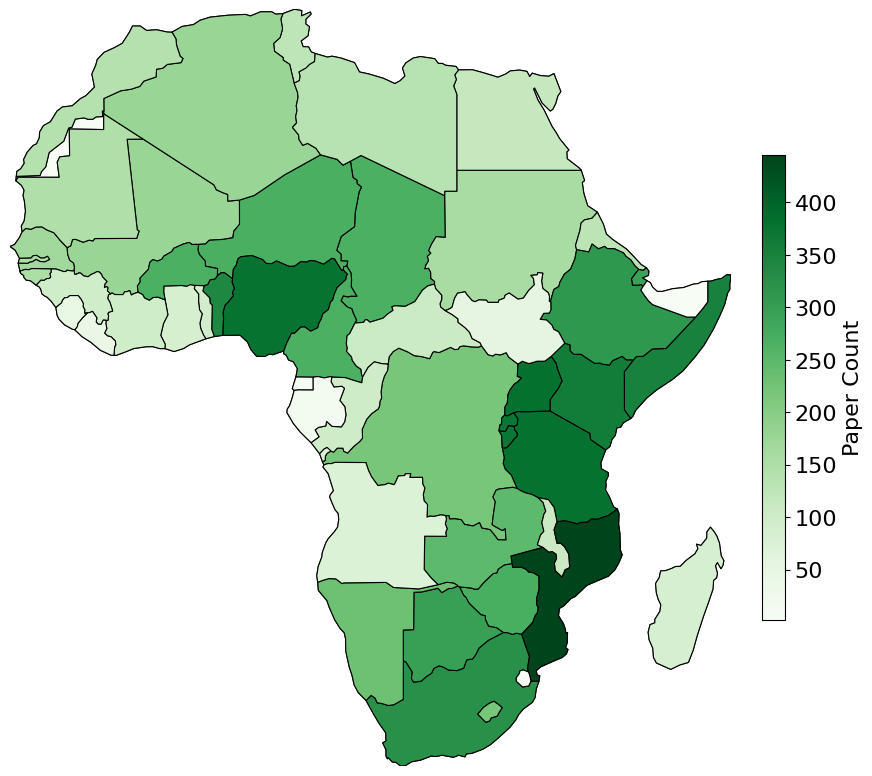

In [ ]:
countries_count = getcountries2(data_categ, startyear =  2019, endyear = 2024)
if "NA" in countries_count:
    countries_count["Namibia"] = countries_count.pop("NA")
plotmapxtra(countries_count)

In [ ]:
countries_count.most_common(10)

[('Mozambique', 445),
 ('Uganda', 382),
 ('Tanzania', 379),
 ('Nigeria', 378),
 ('Rwanda', 372),
 ('Burundi', 371),
 ('Kenya', 361),
 ('Somalia', 352),
 ('Benin', 341),
 ('South Africa', 325)]

## How many paper worked on code-mixed data?


In [ ]:
# Function to check if 'codex' or 'codr' is in the comma-separated category list
def has_codex_or_codr(category_str):
    if pd.isna(category_str):
        return False
    categories = [c.strip().lower() for c in category_str.split(',')]
    return 'codemixed' in categories or 'code-mixed' in categories

# Apply the function and count matching rows
count = megdata['language'].apply(has_codex_or_codr).sum()

print("Number of rows with 'codex' or 'codr' in Category:", 100*count/len(megdata))

Number of rows with 'codex' or 'codr' in Category: 5.090497737556561


In [ ]:
# which paper created task dataset?
# which paper train language models?
# which paper trained speech representation learning models?

**## which paper created task dataset?**

In [ ]:
megdata['Data?'] = megdata['Data?'].str.strip().str.lower()
megdata['cross-cultural?'] = megdata['cross-cultural?'].str.strip().str.lower()
megdata['translated?'] = megdata['translated?'].str.strip().str.lower()
# Filter rows where 'Data?' is 'yes'
filtmeg = megdata[megdata['Data?'] == 'yes']
print(len(filtmeg), len(filtmeg)/len(megdata))

401 0.45361990950226244


In [ ]:
# Filter rows where 'Data?' is 'yes'
ccfiltmeg = filtmeg[filtmeg['cross-cultural?'] == 'yes']

In [ ]:
trfiltmeg = filtmeg[filtmeg['translated?'] == 'yes']

In [ ]:
trfiltmeg

,title,url,year,Category,language,Data?,cross-cultural?,translated?
23,global mmlu: understanding and addressing cult...,https://www.semanticscholar.org/paper/4379bdfe...,2024,"culture, bias, knowledge-based question answering","amharic, arabic, bengali, chinese, czech, dutc...",yes,yes,yes
24,multilingual trolley problems for language models,https://www.semanticscholar.org/paper/442ce43f...,2024,"fairness, ai ethics, large language model, cul...","afrikaans, amharic, arabic, azerbaijani, belar...",yes,yes,yes
26,all languages matter: evaluating lmms on cultu...,https://www.semanticscholar.org/paper/49bb41b6...,2024,"multimodality, culture, visual question answering","afrikaans, albanian, amharic, armenian, assame...",yes,yes,yes
27,amharic llama and llava: multimodal llms for l...,https://www.semanticscholar.org/paper/52512a73...,2024,"vision language model, data augmentation, mult...",amharic,yes,no,yes
29,the evolution of darija open dataset: introduc...,https://www.semanticscholar.org/paper/60f4bc3e...,2024,"dialect studies, culture, mt","moroccan arabic, arabic dialect",yes,no,yes
...,...,...,...,...,...,...,...,...
868,i gbo s um 1500 - i ntroducing the i gbo t ext...,https://www.semanticscholar.org/paper/d3930740...,2022,text summarization,igbo,yes,no,yes
875,sd-qa: spoken dialectal question answering for...,https://www.semanticscholar.org/paper/e72a2a72...,2021,"spoken question answering, transfer learning","swahili, arabic, bengali, english, kenyan swah...",yes,yes,yes
877,an open dataset and model for language identif...,https://www.semanticscholar.org/paper/1e238947...,2023,lid,"english,tunisian arabic,afrikaans,amharic,moro...",yes,yes,yes
880,the construction and evaluation of the leaftop...,https://www.semanticscholar.org/paper/a0164146...,2022,information extraction,"swahili,soli,chadian arabic,lega-mwenga,ndali,...",yes,no,yes


In [ ]:
ccfiltmeg

,title,url,year,Category,language,Data?,cross-cultural?,translated?
1,a continual pre-training approach to tele-tria...,https://www.semanticscholar.org/paper/42aa79b8...,2023,"ai in healthcare, intent classification, adapt...","swahili, english, codemixed",yes,yes,no
3,sign-to-speech model for sign language underst...,https://www.semanticscholar.org/paper/214b487f...,2021,"sign language, sign-to-speech, transfer learning",nigerian sign language,yes,yes,no
4,using radio archives for low-resource speech r...,https://www.semanticscholar.org/paper/444d64a2...,2021,"speech, asr, speech representation learning, s...","french, guinea kpelle, konyanka maninka, north...",yes,yes,no
9,grammatical error correction for low-resource ...,https://www.semanticscholar.org/paper/1a907904...,2024,"grammatical error correction, rule-based nlp, ...",zarma,yes,yes,no
14,emma-500: enhancing massively multilingual ada...,https://www.semanticscholar.org/paper/21431a69...,2024,"pre-training datasets, data filtering, commonc...","ghotuo,acoli,adangme,adhola,afrikaans,aghem,es...",yes,yes,no
...,...,...,...,...,...,...,...,...
871,b uilding t ext and s peech d atasets for l ow...,https://www.semanticscholar.org/paper/2dcc000c...,2022,"mt, asr, transfer learning","ganda , english, masaaba, swahili, nyankole, a...",yes,yes,no
872,kenswquad—a question answering dataset for swa...,https://www.semanticscholar.org/paper/2f98bb1a...,2022,mrc,swahili,yes,yes,no
875,sd-qa: spoken dialectal question answering for...,https://www.semanticscholar.org/paper/e72a2a72...,2021,"spoken question answering, transfer learning","swahili, arabic, bengali, english, kenyan swah...",yes,yes,yes
877,an open dataset and model for language identif...,https://www.semanticscholar.org/paper/1e238947...,2023,lid,"english,tunisian arabic,afrikaans,amharic,moro...",yes,yes,yes


## which papers are in a particular categorization

In [ ]:
# which papers are from which general category
def maps_to_query(row, query, mapping):
    # Split the comma-separated phrases
    phrases = [x.strip() for x in row.split(',')]
    # Map each phrase and check if any map to the query category
    return any(mapping.get(phrase) == query for phrase in phrases)

def categorypapers(data_categ, query_category, catkeys, startyear = 2019, endyear = 2024):
  allpapers = []
  for item in data_categ:
    filtered_df = data_categ[item].query(f'{startyear} <= year <= {endyear}')
    allpapers.append(filtered_df[["title", "url", "year", "Category", "language", "Data?"]])
  mergedt_df = pd.concat(allpapers, ignore_index=True)
  # Apply the filtering
  filtered_df = mergedt_df[mergedt_df['Category'].apply(lambda x: maps_to_query(x, query_category, catkeys))]
  print(len(filtered_df))
  return filtered_df


def getsubcat(df, query = "sentiment analysis"):
  # Assuming df is your DataFrame
  pattern = r'\|' + query
  #filtered_df = df[df['Category'].str.contains(r'\|sentiment', na=False)]
  filtered_df = df[df['Category'].fillna('').apply(lambda x: query in [cat.strip() for cat in x.split(',')])]
  print(len(filtered_df))
  return filtered_df

In [ ]:
query_category = "Natural Language Understanding"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

191


,title,url,year,Category,language,Data?
1,a continual pre-training approach to tele-tria...,https://www.semanticscholar.org/paper/42aa79b8...,2023,"ai in healthcare, intent classification, adapt...","swahili, english, codemixed",yes
8,angofa: leveraging ofa embedding initializatio...,https://www.semanticscholar.org/paper/14023dc6...,2024,"pretrained language model, language modeling, ...","chokwe, kimbundu, kikongo, luba-lulua, umbundu",no
14,emma-500: enhancing massively multilingual ada...,https://www.semanticscholar.org/paper/21431a69...,2024,"pre-training datasets, data filtering, commonc...","ghotuo,acoli,adangme,adhola,afrikaans,aghem,es...",yes
21,leveraging ai and sentiment analysis for forec...,https://www.semanticscholar.org/paper/3c059f5a...,2024,"social media, sentiment analysis","french, english, african english, mauritian cr...",yes
30,a deep convolutional neural network-based mode...,https://www.semanticscholar.org/paper/659ca8c1...,2024,"sentiment analysis, social media, youtube",hausa,yes
...,...,...,...,...,...,...
830,chatgpt beyond english: towards a comprehensiv...,https://www.semanticscholar.org/paper/dfbfa21a...,2023,"large language model, commonsense reasoning, r...","english, swahili",no
837,performance analysis of speech encoders for lo...,https://www.semanticscholar.org/paper/60fc698b...,2024,"speech, asr, speech act classification, slot f...",tunisian arabic,no
857,izindaba-tindzaba: machine learning news categ...,https://www.semanticscholar.org/paper/a4d4741d...,2023,"text classification, word embeddings, transfer...","zulu, swati",yes
873,puoberta: training and evaluation of a curated...,https://www.semanticscholar.org/paper/3448e136...,2023,"language modeling, transfer learning, ner, pos...",tswana,no


In [ ]:
# which of the categorization paper above belongs to a finegrained category
getsubcat(catpapers, query = "sentiment analysis") # hate speech detection sentiment analysis nli

76


,title,url,year,Category,language,Data?
21,leveraging ai and sentiment analysis for forec...,https://www.semanticscholar.org/paper/3c059f5a...,2024,"social media, sentiment analysis","french, english, african english, mauritian cr...",yes
30,a deep convolutional neural network-based mode...,https://www.semanticscholar.org/paper/659ca8c1...,2024,"sentiment analysis, social media, youtube",hausa,yes
35,inkubalm: a small language model for low-resou...,https://www.semanticscholar.org/paper/74a941cc...,2024,"large language model, sentiment analysis, nli,...","english, french, swahili, yoruba, hausa, zulu,...",no
39,egybert: a large language model pretrained on ...,https://www.semanticscholar.org/paper/7facf58f...,2024,"large language model, language modeling, senti...","arabic dialect, egyptian arabic",yes
42,beyond metrics: evaluating llms' effectiveness...,https://www.semanticscholar.org/paper/80d1cebc...,2024,"sentiment analysis, large language model, culture","code-mixed, english, swahili, sheng",no
...,...,...,...,...,...,...
716,"dialectbench: a nlp benchmark for dialects, va...",https://www.semanticscholar.org/paper/07c53cf7...,2024,"dialect studies, mrc, question answering, depe...","swahili, algerian arabic,egyptian arabic,egypt...",yes
732,creoleval: multilingual multitask benchmarks f...,https://www.semanticscholar.org/paper/5bf13c31...,2023,"creoles studies, pos, sentiment analysis, rela...","english, hawaiian pidgin english, saint lucian...",yes
767,transfer learning for code-mixed data: do pret...,https://www.semanticscholar.org/paper/1eb4471c...,2023,"sentiment analysis, ner, cross-lingual transfe...","english, nigerian pidgin, hinglish, hindi, mal...",no
778,investigating sentiment-bearing words- and emo...,https://www.semanticscholar.org/paper/b6044fc4...,2023,"sentiment analysis, distant supervision, dicti...","pedi, tswana, southern sotho, english, code-mixed",yes


In [ ]:
query_category = "Syntax: Tagging, Chunking and Parsing"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

68


,title,url,year,Category,language,Data?
73,a multilingual sentiment lexicon for low-resou...,https://www.semanticscholar.org/paper/d5ea3c56...,2024,"sentiment analysis, transfer learning, pos","english, afrikaans, sepedi, zulu, french, luba...",yes
92,fonmtl: towards multitask learning for the fon...,https://www.semanticscholar.org/paper/d8f8634b...,2023,"multi-task learning, pos, ner, transfer learning",fon,no
102,data-efficient cross-lingual transfer with lan...,https://www.semanticscholar.org/paper/5382f5b9...,2022,"cross-lingual transfer, transfer learning, dep...","wolof, amharic, bambara, nigerian pidgin, afri...",no
111,beyond the imitation game: quantifying and ext...,https://www.semanticscholar.org/paper/bd1331b2...,2022,"sts, grammar induction, lid, large language model","afrikaans, amharic, igbo, hausa, swahili, kiny...",yes
141,contemporary amharic corpus: automatically mor...,https://www.semanticscholar.org/paper/a0751f90...,2021,pos,amharic,yes
...,...,...,...,...,...,...
790,"lateral inversions, word form/order, unnamed g...",https://www.semanticscholar.org/paper/3cf368d6...,2024,"syntactic parsing, mt","igala, english",no
797,early child language resources and corpora dev...,https://www.semanticscholar.org/paper/6b370c8e...,2024,"child language, grammar development","south transvaal ndebele, xhosa, zulu, pedi, so...",yes
798,bootstrapping syntactic resources from isizulu...,https://www.semanticscholar.org/paper/7cad4d59...,2024,"cross-lingual transfer, computational grammar","zulu, swati",yes
838,development of linguistically annotated parall...,https://www.semanticscholar.org/paper/55cdfada...,2021,pos,"south transvaal ndebele, xhosa, zulu, swati, e...",yes


In [ ]:
query_category = 'Interpreting and Analyzing NLP Models'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

38


,title,url,year,Category,language,Data?
16,cross-linguistic examination of machine transl...,https://www.semanticscholar.org/paper/298d9b93...,2024,"mt, transfer learning, interpretanalysis","modern standard arabic, levantine arabic, zulu...",no
32,controlled evaluation of syntactic knowledge i...,https://www.semanticscholar.org/paper/6cbd5d23...,2024,"interpretanalysis, syntactic probing",swahili,no
40,domain-specific translation with open-source l...,https://www.semanticscholar.org/paper/80387a3a...,2024,"mt, interpretanalysis","swahili, english, french",no
61,in-context example selection via similarity se...,https://www.semanticscholar.org/paper/c0c9a3d2...,2024,"mt, large language model, in-context learning,...","swahili, wolof, english, french, german",no
67,multi-fact: assessing multilingual llms' multi...,https://www.semanticscholar.org/paper/cc72e18f...,2024,"fact checking, interpretanalysis","english, german, french, spanish, swahili, ara...",no
71,what are the limits of cross-lingual dense pas...,https://www.semanticscholar.org/paper/d241497f...,2024,"cross-lingual ir, ir, transfer learning, cross...","amharic, arabic, khmer, thai, english",yes
79,do discrete self-supervised representations of...,https://www.semanticscholar.org/paper/f4954280...,2024,interpretanalysis,yoruba,no
119,translating the unseen? yorùbá → english mt in...,https://www.semanticscholar.org/paper/266e3005...,2021,"mt, interpretanalysis","yoruba, english",no
154,on optimal transformer depth for low-resource ...,https://www.semanticscholar.org/paper/1780663e...,2020,"mt, interpretanalysis","tswana, sepedi, afrikaans, german, russian",no
162,analyzing autoencoder-based acoustic word embe...,https://www.semanticscholar.org/paper/39981009...,2020,"acoustic word embeddings, speaker identificati...","spanish, hausa, croatian, swedish, turkish, ma...",no


In [ ]:
query_category = 'Human-Centered NLP'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

11


,title,url,year,Category,language,Data?
194,enhancing communication equity: evaluation of ...,https://www.semanticscholar.org/paper/1466c0f4...,2024,"hci, asr",english african accent,no
195,low-resourced languages and online knowledge r...,https://www.semanticscholar.org/paper/98eb770d...,2024,hci,"amharic, west central oromo, tigrinya",NaN
196,platform (in)justice: a call for a global rese...,https://www.semanticscholar.org/paper/0573850d...,2023,"hci, panel discussion, socio-technical, ethics",language independent,NaN
197,a need finding study with low-resource languag...,https://www.semanticscholar.org/paper/0a996660...,2023,hci,"amharic, west central oromo, tigrinya",NaN
198,can large language models support medical faci...,https://www.semanticscholar.org/paper/66a4ebd7...,2023,"hci, healthcare, ai facilitator, social media,...","swahili, english, sheng, codemixed",yes
199,the domestication of ai by kenyan digital crea...,https://www.semanticscholar.org/paper/e485a869...,2023,"hci, text generation, code generation",unknown,NaN
200,opportunities and challenges of automatic spee...,https://www.semanticscholar.org/paper/e777f6fd...,2022,"hci, asr",xhosa,no
201,"“everyone wants to do the model work, not the ...",https://www.semanticscholar.org/paper/63d7e40d...,2021,"hci, data usage",unknown,NaN
221,understanding slang with llms: modelling cross...,https://www.semanticscholar.org/paper/41c8ea26...,2024,"slangs, large language model, paraphrase gener...","english, nigerian pidgin",yes
408,wetin dey with these comments? modeling sociol...,https://www.semanticscholar.org/paper/6ef8f996...,2019,"computational sociolinguistics, humancentered","nigerian pidgin, codemixed, nigerian english",yes


In [ ]:
query_category = 'Ethics, Bias, and Fairness'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

29


,title,url,year,Category,language,Data?
10,mm-eval: a multilingual meta-evaluation benchm...,https://www.semanticscholar.org/paper/1b256fb2...,2024,"mathematical reasoning, large language model, ...","arabic, bengali, catalan, german, english, spa...",yes
23,global mmlu: understanding and addressing cult...,https://www.semanticscholar.org/paper/4379bdfe...,2024,"culture, bias, knowledge-based question answering","amharic, arabic, bengali, chinese, czech, dutc...",yes
24,multilingual trolley problems for language models,https://www.semanticscholar.org/paper/442ce43f...,2024,"fairness, ai ethics, large language model, cul...","afrikaans, amharic, arabic, azerbaijani, belar...",yes
31,lexicography saves lives (lsl): automatically ...,https://www.semanticscholar.org/paper/681dcfdb...,2024,"ethics, mt, social good","english,tunisian arabic,afrikaans,akan,amharic...",yes
33,cultural fidelity in large-language models: an...,https://www.semanticscholar.org/paper/6dc96845...,2024,"bias, culture, large language model, question ...","german, greek, indonesian, russian, farsi, por...",no
38,evaluating cultural awareness of llms for yoru...,https://www.semanticscholar.org/paper/7f755abc...,2024,"bias, culture, large language model, cultural ...","yoruba, malayalam, english",yes
45,homograph attacks on maghreb sentiment analyzers,https://www.semanticscholar.org/paper/8c5a23dd...,2024,"sentiment analysis, large language model, homo...","arabic dialect, moroccan arabic, tunisian arab...",no
46,aradice: benchmarks for dialectal and cultural...,https://www.semanticscholar.org/paper/8f07183b...,2024,"bias, cultural bias, large language model, did...","arabic dialect, egyptian arabic",yes
105,the online behaviour of the algerian abusers i...,https://www.semanticscholar.org/paper/81c3b741...,2022,"social media, facebook, computational social s...","algerian arabic, french, code-mixed",yes
164,is machine learning speaking my language? a cr...,https://www.semanticscholar.org/paper/4a5aaf79...,2020,"bias, ai ethics","english, chinese, urdu, farsi, arabic, french,...",no


In [ ]:
query_category = "Dialogue and Interactive Systems"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

7


,title,url,year,Category,language,Data?
36,deep learning based amharic chatbot for faqs i...,https://www.semanticscholar.org/paper/77baa6e2...,2024,"education, dialogue system, question answering",amharic,no
139,a multilingual african embedding for faq chatbots,https://www.semanticscholar.org/paper/8304a37c...,2021,"dialogue system, ai in healthcare, question an...","english, french, arabic, tunisian arabic, igbo...",yes
246,predicting the target word of game-playing con...,https://www.semanticscholar.org/paper/bdafb927...,2024,"dialogue system, parameter-efficient adapter, ...","indian english, nigerian english, african english",no
249,task-oriented dialog systems for the senegales...,https://www.semanticscholar.org/paper/cfe2ac0c...,2024,"dialogue system, intent recognition, slot fill...","wolof, french",no
460,md3: the multi-dialect dataset of dialogues,https://www.semanticscholar.org/paper/19bd9ff0...,2023,"speech, dialogue, dialect studies, dialectal v...","english dialect, indian english, african engli...",Yes
562,tagengo: a multilingual chat dataset,https://www.semanticscholar.org/paper/a43892e9...,2024,"transfer learning, dialogue system, dialogue g...","english, portuguese, spanish, russian, italian...",yes
748,afriwoz: corpus for exploiting cross-lingual t...,https://www.semanticscholar.org/paper/dc9f9419...,2023,"cross-lingual transfer, dialogue generation, t...","english, nigerian pidgin, yoruba, hausa, wolof...",yes


In [ ]:
query_category = 'NLP Applications'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

25


,title,url,year,Category,language,Data?
1,a continual pre-training approach to tele-tria...,https://www.semanticscholar.org/paper/42aa79b8...,2023,"ai in healthcare, intent classification, adapt...","swahili, english, codemixed",yes
15,"afrimed-qa: a pan-african, multi-specialty, me...",https://www.semanticscholar.org/paper/24353a79...,2024,"question answering, ai in healthcare, large la...","english, african english",yes
31,lexicography saves lives (lsl): automatically ...,https://www.semanticscholar.org/paper/681dcfdb...,2024,"ethics, mt, social good","english,tunisian arabic,afrikaans,akan,amharic...",yes
36,deep learning based amharic chatbot for faqs i...,https://www.semanticscholar.org/paper/77baa6e2...,2024,"education, dialogue system, question answering",amharic,no
50,ai literacy in low-resource languages: insight...,https://www.semanticscholar.org/paper/9c2b58ed...,2024,"education, ai literacy, social media, linkedin...",yoruba,yes
54,adapting mental health prediction tasks for cr...,https://www.semanticscholar.org/paper/ae760736...,2024,"ai in healthcare, large language model, meta-l...","english, swahili",yes
66,analyzing covid-19 vaccination sentiments in n...,https://www.semanticscholar.org/paper/cbf2f600...,2024,"sentiment analysis, social media, twitter, ai ...","codemixed, english",yes
94,optical character recognition and transcriptio...,https://www.semanticscholar.org/paper/f344e5d8...,2023,"ocr, education","amazigh, standard moroccan tamazight",yes
120,congolese swahili machine translation for huma...,https://www.semanticscholar.org/paper/297bbef2...,2021,"mt, humanitarian response","congolese swahili, swahili, french",no
139,a multilingual african embedding for faq chatbots,https://www.semanticscholar.org/paper/8304a37c...,2021,"dialogue system, ai in healthcare, question an...","english, french, arabic, tunisian arabic, igbo...",yes


In [ ]:
query_category = 'kids'
query_category = 'Interpreting and Analyzing NLP Models'
query_category = 'Ethics, Bias, and Fairness'
query_category = 'NLP Applications'
#query_category = 'Sign Language'
#query_category = "Multimodality and Language Grounding"
query_category = "Syntax: Tagging, Chunking and Parsing"
query_category = "Natural Language Understanding"
query_category = "Efficient/Low-Resource Methods for NLP"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

In [ ]:
query_category = "Discourse and Pragmatics"
query_category = "Computational Social Science and Cultural Analytics"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

In [ ]:
query_category = 'Interpreting and Analyzing NLP Models'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

38


,title,url,year,Category,language,Data?
16,cross-linguistic examination of machine transl...,https://www.semanticscholar.org/paper/298d9b93...,2024,"mt, transfer learning, interpretanalysis","modern standard arabic, levantine arabic, zulu...",no
32,controlled evaluation of syntactic knowledge i...,https://www.semanticscholar.org/paper/6cbd5d23...,2024,"interpretanalysis, syntactic probing",swahili,no
40,domain-specific translation with open-source l...,https://www.semanticscholar.org/paper/80387a3a...,2024,"mt, interpretanalysis","swahili, english, french",no
61,in-context example selection via similarity se...,https://www.semanticscholar.org/paper/c0c9a3d2...,2024,"mt, large language model, in-context learning,...","swahili, wolof, english, french, german",no
67,multi-fact: assessing multilingual llms' multi...,https://www.semanticscholar.org/paper/cc72e18f...,2024,"fact checking, interpretanalysis","english, german, french, spanish, swahili, ara...",no
71,what are the limits of cross-lingual dense pas...,https://www.semanticscholar.org/paper/d241497f...,2024,"cross-lingual ir, ir, transfer learning, cross...","amharic, arabic, khmer, thai, english",yes
79,do discrete self-supervised representations of...,https://www.semanticscholar.org/paper/f4954280...,2024,interpretanalysis,yoruba,no
119,translating the unseen? yorùbá → english mt in...,https://www.semanticscholar.org/paper/266e3005...,2021,"mt, interpretanalysis","yoruba, english",no
154,on optimal transformer depth for low-resource ...,https://www.semanticscholar.org/paper/1780663e...,2020,"mt, interpretanalysis","tswana, sepedi, afrikaans, german, russian",no
162,analyzing autoencoder-based acoustic word embe...,https://www.semanticscholar.org/paper/39981009...,2020,"acoustic word embeddings, speaker identificati...","spanish, hausa, croatian, swedish, turkish, ma...",no


In [ ]:
query_category = "Syntax: Tagging, Chunking and Parsing"
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)
catpapers

68


,title,url,year,Category,language,Data?
73,a multilingual sentiment lexicon for low-resou...,https://www.semanticscholar.org/paper/d5ea3c56...,2024,"sentiment analysis, transfer learning, pos","english, afrikaans, sepedi, zulu, french, luba...",yes
92,fonmtl: towards multitask learning for the fon...,https://www.semanticscholar.org/paper/d8f8634b...,2023,"multi-task learning, pos, ner, transfer learning",fon,no
102,data-efficient cross-lingual transfer with lan...,https://www.semanticscholar.org/paper/5382f5b9...,2022,"cross-lingual transfer, transfer learning, dep...","wolof, amharic, bambara, nigerian pidgin, afri...",no
111,beyond the imitation game: quantifying and ext...,https://www.semanticscholar.org/paper/bd1331b2...,2022,"sts, grammar induction, lid, large language model","afrikaans, amharic, igbo, hausa, swahili, kiny...",yes
141,contemporary amharic corpus: automatically mor...,https://www.semanticscholar.org/paper/a0751f90...,2021,pos,amharic,yes
...,...,...,...,...,...,...
790,"lateral inversions, word form/order, unnamed g...",https://www.semanticscholar.org/paper/3cf368d6...,2024,"syntactic parsing, mt","igala, english",no
797,early child language resources and corpora dev...,https://www.semanticscholar.org/paper/6b370c8e...,2024,"child language, grammar development","south transvaal ndebele, xhosa, zulu, pedi, so...",yes
798,bootstrapping syntactic resources from isizulu...,https://www.semanticscholar.org/paper/7cad4d59...,2024,"cross-lingual transfer, computational grammar","zulu, swati",yes
838,development of linguistically annotated parall...,https://www.semanticscholar.org/paper/55cdfada...,2021,pos,"south transvaal ndebele, xhosa, zulu, swati, e...",yes


In [ ]:
data_categ['manual_papers']

,paperId,title,abstract,url,year,score,query,Unnamed: 7,language,Category,...,Model?,rModel?,Toolkit?,Evaluation?,rCode?,Project?,Shared task?,Comment/Note,Unnamed: 24,Unnamed: 25
0,e113f849feab96255b17b73ea5bca064174765e5,ntrex-128 – news test references for mt evalua...,"We release NTREX-128, a data set for machine t...",https://www.semanticscholar.org/paper/e113f849...,2022,315.83150,NTREX-128 – News Test References for MT Evalua...,NaN,"afrikaans, albanian, amharic, arabic, azerbaij...","mt, mt evaluation",...,no,no,NaN,NaN,no,NaN,NaN,NaN,"Afrikaans, Albanian, Amharic, Arabic, Azerbaij...",NaN
1,687b13c44f849d23c2496996b5da83e706094db9,beyond english-centric multilingual machine tr...,Existing work in translation demonstrated the ...,https://www.semanticscholar.org/paper/687b13c4...,2020,215.37960,Beyond English-Centric Multilingual Machine Tr...,NaN,"afrikaans, japanese, danish, korean, dutch, vi...","mt, bitext mining",...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,"Afrikaans, Japanese, Danish, Korean, Dutch, Vi...",NaN
2,789b8487da7188442085983caba3ffaae05531e9,the flores-101 evaluation benchmark for low-re...,One of the biggest challenges hindering progre...,https://www.semanticscholar.org/paper/789b8487...,2021,261.88437,The FLORES-101 Evaluation Benchmark for Low-Re...,NaN,"english, afrikaans,amharic,fula,ganda,hausa,ig...","mt, mt evaluation",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"afr, amh, ara, hye, asm, ast, azj, bel, ben, b...",NaN
3,e19b54ad4c1c8af045069e9cac350ffc2ce60e1a,no language left behind: scaling human-centere...,Driven by the goal of eradicating language bar...,https://www.semanticscholar.org/paper/e19b54ad...,2022,236.94017,No Language Left Behind: Scaling Human-Centere...,NaN,"english,tunisian arabic,afrikaans,akan,amharic...","mt, mt evaluation, transfer learning, knowledg...",...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,"aeb,afr,aka,amh,ary,arz,bam,bem,cjk,dik,dyu,ew...",NaN
4,964bd39b546f0f6625ff3b9ef1083f797807ef2e,bloom: a 176b-parameter open-access multilingu...,Large language models (LLMs) have been shown t...,https://www.semanticscholar.org/paper/964bd39b...,2022,258.08740,BLOOM: A 176B-Parameter Open-Access Multilingu...,NaN,"akan, arabic, assamese, bambara, basque, benga...","language modeling, large language model, sts, mt",...,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,"Akan, Arabic, Assamese, Bambara, Basque, Benga...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,77638cb15b7c2cbb031eb103081ce881297904b3,memory-efficient nllb-200: language-specific e...,The recently released NLLB-200 is a set of mul...,https://www.semanticscholar.org/paper/77638cb1...,2022,352.88605,Memory-efficient NLLB-200: Language-specific E...,NaN,"tswana,tigrinya,pedi,yoruba,luo (kenya and tan...","mt, pruning",...,yes,NaN,NaN,NaN,NaN,NaN,NaN,"tsn, vie, rus, eng, fra, por, jpn, kor, fin, t...",NaN,NaN
205,a0164146442baba6348bd9e297550adf22cba9ac,the construction and evaluation of the leaftop...,The LEAFTOP (language extracted automatically ...,https://www.semanticscholar.org/paper/a0164146...,2022,305.11950,The Construction and Evaluation of the LEAFTOP...,NaN,"swahili,soli,chadian arabic,lega-mwenga,ndali,...",information extraction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,6e6e5b13ea33cc4dc4bf0dae8f0febe97bdedfc8,ffstc: fongbe to french speech translation corpus,"In this paper, we introduce the Fongbe to Fren...",https://www.semanticscholar.org/paper/6e6e5b13...,2024,242.62187,FFSTC: Fongbe to French Speech Translation Corpus,NaN,"fon, french",speech translation,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,ead721b629ed84621c4bf3c677575a73b307f9ff,employing wikipedia as a resource for named en...,We propose a novel approach for rapid prototyp...,https://www.semanticscholar.org/paper/ead721b6...,2021,292.84918,Employing Wikipedia as a resource for Named En...,NaN,"zulu, malayalam","ner, weak supervision, transfer learning",...,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
query_category = 'Efficient/Low-Resource Methods for NLP'
catpapers = categorypapers(data_categ, query_category, catkeys,startyear = 2019, endyear = 2024)

532


In [ ]:
# which of the categorization paper above belongs to a finegrained category
getsubcat(catpapers, query =  "meta-learning") # hate speech detection sentiment analysis nli

9


,title,url,year,Category,language,Data?
5,adversarial meta sampling for multilingual low...,https://www.semanticscholar.org/paper/535f1684...,2020,"asr, transfer learning, meta-learning","bengali, tagalog, zulu, turkish, lithuanian, g...",no
54,adapting mental health prediction tasks for cr...,https://www.semanticscholar.org/paper/ae760736...,2024,"ai in healthcare, large language model, meta-l...","english, swahili",yes
102,data-efficient cross-lingual transfer with lan...,https://www.semanticscholar.org/paper/5382f5b9...,2022,"cross-lingual transfer, transfer learning, dep...","wolof, amharic, bambara, nigerian pidgin, afri...",no
133,cross-lingual adaption model-agnostic meta-lea...,https://www.semanticscholar.org/paper/497854f6...,2021,"meta-learning, nli, transfer learning, cross-l...",swahili,no
280,good meta-tasks make a better cross-lingual me...,https://www.semanticscholar.org/paper/a92b837f...,2023,"question answering, meta-learning, transfer le...","swahili, english",no
329,know where you're going: meta-learning for par...,https://www.semanticscholar.org/paper/990f7efd...,2022,"meta learning, ner, parameter-efficient adapte...","hindi, afrikaans, azerbaijani, lithuanian, est...",no
332,meta-xnlg: a meta-learning approach based on l...,https://www.semanticscholar.org/paper/ac247d12...,2022,"cross-lingual transfer, transfer learning, met...",swahili,no
375,zero-shot cross-lingual transfer with meta lea...,https://www.semanticscholar.org/paper/56d753c5...,2020,"cross-lingual transfer , meta-learning, nli",swahili,NaN
453,meta learning text-to-speech synthesis in over...,https://www.semanticscholar.org/paper/c990c671...,2024,"tts, meta-learning","ghotuo,arum,afade,algerian saharan arabic,afar...",yes


In [ ]:
getsubcat(catpapers, query = "adaptive pretraining")

38


,title,url,year,Category,language,Data?
1,a continual pre-training approach to tele-tria...,https://www.semanticscholar.org/paper/42aa79b8...,2023,"ai in healthcare, intent classification, adapt...","swahili, english, codemixed",yes
6,unifiedcrawl: aggregated common crawl for affo...,https://www.semanticscholar.org/paper/014fb2f0...,2024,"language modeling, adaptive pretraining, trans...","hausa, pashto, amharic, yoruba, sudanese, sind...",NaN
14,emma-500: enhancing massively multilingual ada...,https://www.semanticscholar.org/paper/21431a69...,2024,"pre-training datasets, data filtering, commonc...","ghotuo,acoli,adangme,adhola,afrikaans,aghem,es...",yes
74,mala-500: massive language adaptation of large...,https://www.semanticscholar.org/paper/de643836...,2024,"language modeling, adaptive pretraining, text ...","akan,isoko,kwangali,swahili,okpe (southwestern...",no
78,atlas-chat: adapting large language models for...,https://www.semanticscholar.org/paper/ebb9f90d...,2024,"large language model, mt, sentiment analysis, ...",moroccan arabic,yes
218,naijahate: evaluating hate speech detection on...,https://www.semanticscholar.org/paper/3e2e2ee0...,2024,"hate speech detection, bias, pretrained langua...","english, nigerian pidgin",Yes
229,walia-llm: enhancing amharic-llama by integrat...,https://www.semanticscholar.org/paper/5d8bc6e9...,2024,"large language model, adaptive pretraining, da...","amharic, english",yes
239,afriinstruct: instruction tuning of african la...,https://www.semanticscholar.org/paper/9470724c...,2024,"large language model, mt, text classification,...","english, french, amharic, hausa, igbo, west ce...",yes
252,nglueni: benchmarking and adapting pretrained ...,https://www.semanticscholar.org/paper/df2db650...,2024,"pretrained language model, nlu, ner, pos, text...","zulu, xhosa, south transvaal ndebele, swati",yes
278,"sib-200: a simple, inclusive, and big evaluati...",https://www.semanticscholar.org/paper/a5175753...,2023,"text classification, annotation projection, cr...","english, acehnese (arabic script), acehnese (l...",Yes


In [ ]:
# How about methods?
query_category = "Adaptive pretraining"
categorypapers(data_categ, query_category, catkeys2,startyear = 2019, endyear = 2024)

0


,title,url,year,Category,language,Data?
